In [19]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import json
import nltk
import wordcloud
import spacy
import random
import ast

from tqdm import tqdm

In [50]:
base_path = "/datapool/chris/ITA_DATA/ITA_WS_2020/datasets/"

df = pd.read_csv(base_path + "food-com/RAW_recipes.csv")

def convert(column_string):
    result = ast.literal_eval(column_string)
    if result:
        return [f"{i}" for i in result] 
    return np.nan

# convert all the strings to lists in
for column in ["tags", "steps", "ingredients"]:
    df[column] = df[column].apply(convert)

display(df.head())

name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object


name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  [60-minutes-or-less, time-to-make, course, mai...   
1  [30-minutes-or-less, time-to-make, course, mai...   
2  [time-to-make, course, preparation, main-dish,...   
3  [60-minutes-or-less, time-to-make, course, mai...   
4  [weeknight, time-to-make, course, main-ingredi...   

                                    nutrition  n_steps  \
0       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11   
1   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9   
2  [269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]        6   
3   [368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]       11   
4   [352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]        5   

                                               steps  \
0  [make a choice and proceed with recipe, depend...   
1  [preheat oven to 425 degrees f, press dough in...   
2  [brown ground beef in large pot, add chopped o...   
3  [place potatoes in a large pot of lightly salt...   
4  [mix all ingredients& boil for 2 1 / 2 hours ,...   

                                         description  \
0  autumn is my favorite time of year to cook! th...   
1  this recipe calls for the crust to be prebaked...   
2  this modified version of 'mom's' chili was a h...   
3  this is a super easy, great tasting, make ahea...   
4  my dh's amish mother raised him on this recipe...   

                                         ingredients  n_ingredients  
0  [winter squash, mexican seasoning, mixed spice...              7  
1  [prepared pizza crust, sausage patty, eggs, mi...              6  
2  [ground beef, yellow onions, diced tomatoes, t...             13  
3  [spreadable cheese with garlic and herbs, new ...             11  
4  [tomato juice, apple cider vinegar, sugar, sal...              8

In [56]:
print(f"Number of recipes before dropna: {len(df)}")
df.dropna(inplace=True, subset=["steps","ingredients"])
print(f"Number of recipes after dropna: {len(df)}")

Number of recipes before dropna: 231637
Number of recipes after dropna: 231636


## Ingredients

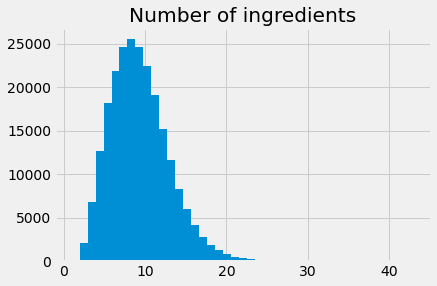

Median number of ingredients: 9.0
Std. deviation of number of ingredients: 3.73


In [57]:
def count_ingredients(ingredients): 
    if isinstance(ingredients, list):
        return len(ingredients)
    else:
        return 0

df['n_ingredients'] = df.ingredients.apply(count_ingredients)

#plot distribution
plt.title("Number of ingredients")
plt.hist(df.n_ingredients.tolist(), bins=max(df.n_ingredients.tolist()))
plt.show()

print(f"Median number of ingredients: {df.n_ingredients.median()}")
print(f"Std. deviation of number of ingredients: {df.n_ingredients.std():.2f}")

The median number of ingredients per recipe is 9, which seems plausible. There are some recipes that require a lot of ingredients, i.e. the distribution is long tailed. However, the majority has 1-20 ingredients.

In [71]:
df[df.n_ingredients == 0]

Empty DataFrame
Columns: [name, id, minutes, contributor_id, submitted, tags, nutrition, n_steps, steps, description, ingredients, n_ingredients]
Index: []

As one can see, no recipes with no ingredients are present here, so the dataset authors likely already did some preprocessing here.

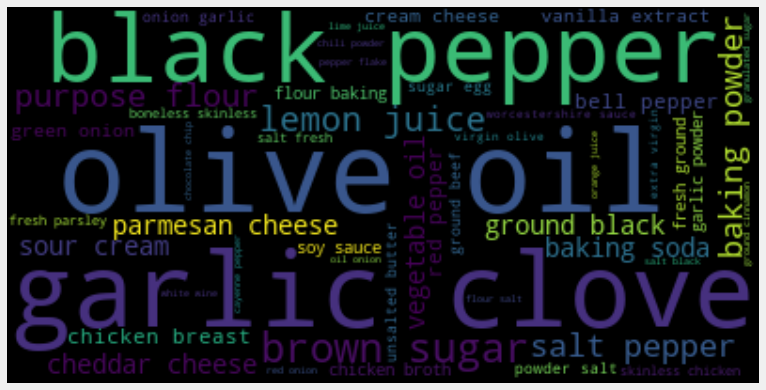

In [59]:
total_ingredients = nltk.flatten(df.ingredients.tolist())
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(total_ingredients))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

As one can see, olive oil is the most prominent ingredient here.

In [73]:
nlp = spacy.load("en_core_web_sm")
processed_ingredients = [nlp(text) for text in random.sample(total_ingredients, 50000)]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if word.pos_ == "NOUN"]

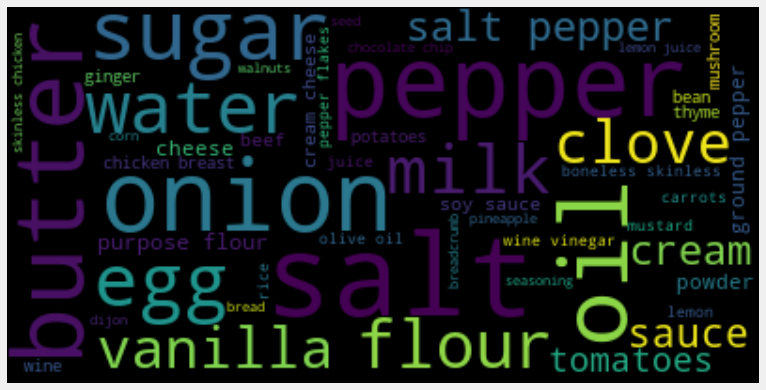

In [74]:
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

In [75]:
# without units (special stopwords)
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "ounce", "ounces","slice","slices", "piece", "pieces", "ADVERTISEMENT"}
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if (word.pos_ == "NOUN" and not word.is_stop)]

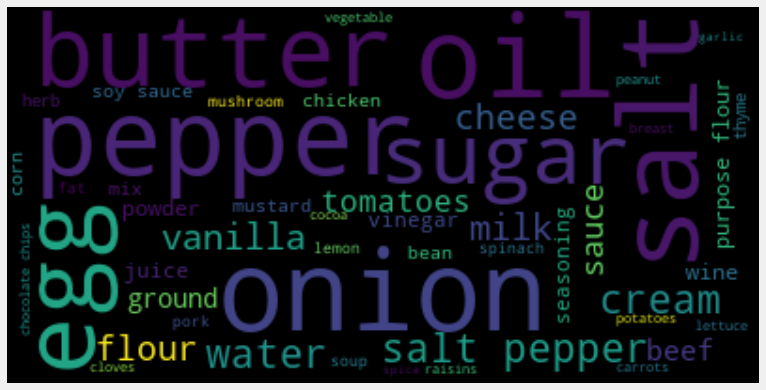

In [76]:
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

## Directions

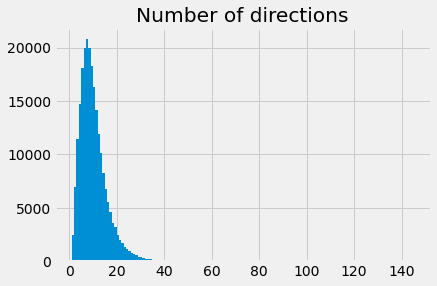

Median number of directions: 9.0
Std. deviation of number of directions: 6.00


In [77]:
def count_directions(directions):
    if isinstance(directions, list):
        return len(directions)
    else:
        return 0

df['n_directions'] = df.steps.apply(count_directions)

#plot distribution
plt.title("Number of directions")
plt.hist(df.n_directions.tolist(), bins=max(df.n_directions.tolist()))
plt.show()

print(f"Median number of directions: {df.n_directions.median()}")
print(f"Std. deviation of number of directions: {df.n_directions.std():.2f}")

In [78]:
df[df.n_steps > 100].head()

name      id  minutes  \
1627   5 cheese crab lasagna with roasted garlic and ...   65007      245   
51528  chocolate raspberry mousse truffle cake   rasp...  192468      240   
51532                    chocolate raspberry ruffle cake  156874     1080   
78633                   easy yeast bread with variations  158120      210   

       contributor_id   submitted  \
1627            87300  2003-06-18   
51528          232669  2006-10-27   
51532           10033  2006-02-21   
78633          182358  2006-02-28   

                                                    tags  \
1627   [weeknight, time-to-make, course, main-ingredi...   
51528  [time-to-make, course, main-ingredient, cuisin...   
51532  [time-to-make, course, main-ingredient, prepar...   
78633  [time-to-make, course, preparation, healthy, b...   

                                               nutrition  n_steps  \
1627         [442.8, 35.0, 27.0, 33.0, 50.0, 60.0, 10.0]      108   
51528       [697.4, 57.0, 249.0, 9.0, 13.0, 105.0, 29.0]      113   
51532  [5080.8, 616.0, 967.0, 25.0, 147.0, 1211.0, 12...      110   
78633    [1784.5, 62.0, 104.0, 151.0, 103.0, 42.0, 99.0]      145   

                                                   steps  \
1627   [roast garlic: place oven rack on second notch...   
51528  [make the chocolate sour cream cake:, preheat ...   
51532  [first of all: these are not typical direction...   
78633  [white bread:, lightly spooning flour into mea...   

                                             description  \
1627   this creamy, gooey, gorgeous white lasagna wil...   
51528  this recipe is the winner, hands down! just in...   
51532  alice medrich recipe, found in baking with jul...   
78633  found online in response to a request and now ...   

                                             ingredients  n_ingredients  \
1627   [garlic, extra virgin olive oil, dry white win...             24   
51528  [cake flour, baking soda, salt, godiva dark ch...             24   
51532  [unsalted butter, pure vanilla extract, all-pu...             13   
78633  [all-purpose flour, dry yeast, sugar, salt, wa...              8   

       n_directions  
1627            108  
51528           113  
51532           110  
78633           145

Some recipies have a lot of instructions (> 100).

In [87]:
for direction in df[df.n_directions == 1]:
    print(direction.n_directions)

['cut all ribs into serving size pieces sprinkle ribs with salt in a dutch oven , brown ribs on all sides in veg oil over medium heat remove ribs from pot saute onions in pot until lightly browned return ribs to pot combine all remaining ingredients in a bowl and mix together- add to pot cover pot and cook over low heat for approx 2 hours , or until tender , stirring occasionally']
['mix , sprinkle lightly on your favorite cut of beef , then cook as desired !']
['mix all ingredients in blender until smooth']
['whisk all ingredients together , bring to boil in medium saucepan , and simmer 45 minutes until thick and reduced to about 1 cup of sauce']
['mix together and dip dip dip !']


While some recipes with no instructions also have no ingredients, there are some which should have instructions. Interesstingly, most of the recipes are for drinks.

In [94]:
# number of words, sentences in directions 
processed_directions = [nlp(direction) for direction in tqdm(nltk.flatten(random.sample(df.steps.tolist(), 5000))) if isinstance(direction, str)]
sentences_per_direction = [len(list(processed_direction.sents)) for processed_direction in tqdm(processed_directions)]

100%|██████████| 48792/48792 [00:00<00:00, 665471.58it/s]


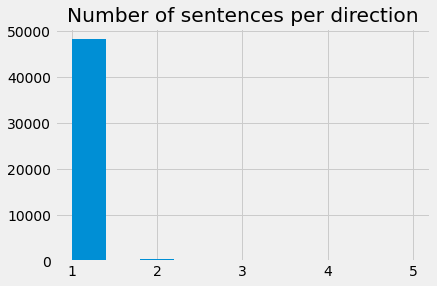

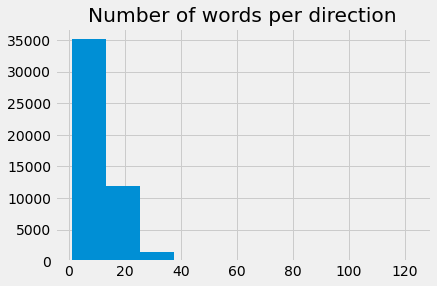

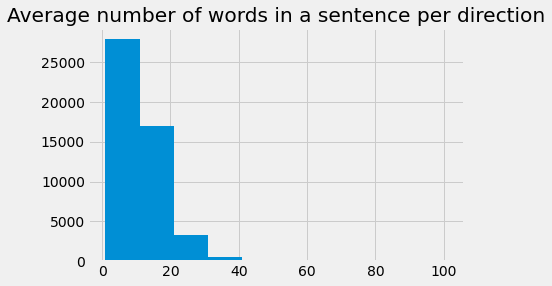

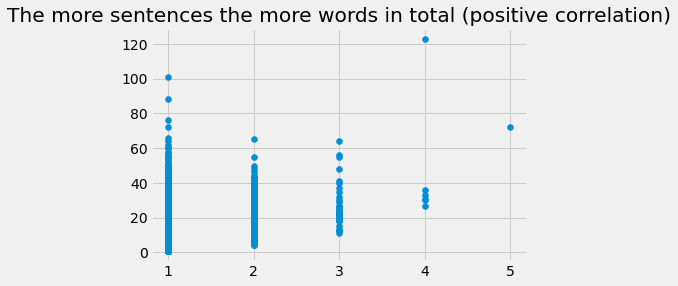

In [95]:
plt.title("Number of sentences per direction")
plt.hist(sentences_per_direction)
plt.show()

words_per_direction = [len(processed_direction) for processed_direction in processed_directions]
plt.title("Number of words per direction")
plt.hist(words_per_direction)
plt.show()

plt.title("Average number of words in a sentence per direction")
plt.hist(np.array(words_per_direction) / np.array(sentences_per_direction))
plt.show()

plt.title("The more sentences the more words in total (positive correlation)")
plt.scatter(sentences_per_direction, words_per_direction)
plt.show()

This is varying quite a lot! So there is no clue if the directions are especially long or short. Of course the correlation between #words and #sentences is positive. Interestingly it is more a cloud than a line, so some variation.

In [109]:
def count_words(directions):
    return len(nlp(" ".join(directions))) 

word_count = [count_words(step) for step in tqdm(random.sample(df.steps.tolist(), 5000))]

100%|██████████| 5000/5000 [00:56<00:00, 87.97it/s]


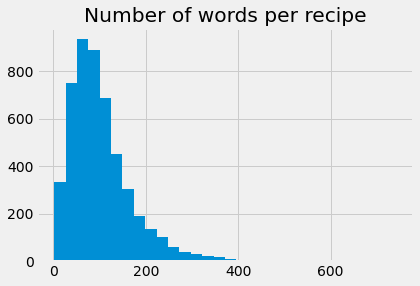

In [110]:
plt.title("Number of words per recipe")
plt.hist(word_count, bins=30)
plt.show()